## **환경 설정**

In [2]:
#빅쿼리 접속
from google.oauth2 import service_account
from google.cloud import bigquery
credential_path = ""
credentials = service_account.Credentials.from_service_account_file(credential_path)
client = bigquery.Client(credentials=credentials, project='road-traffic-safety-388112')

#시각화 라이브러리 호출
import csv
import json
import pandas as pd
import folium
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

#한글 설치
import os
if not os.name == 'posix':
    plt.rc("font", family="Malgun Gothic")

## **시각화 함수 외**

In [4]:
#그래프 함수
def draw_bar_chart(list_x, list_y, chart_title, color_list = '#003f7d'):
    plt.bar(list_x, list_y, color = color_list)
    plt.title(chart_title)
    plt.xticks(list_x, rotation = 45, ha = 'right')
    plt.show()
    
def draw_line_chart(list_x, list_y, chart_title, label_name = 'None', color_list ='#003f7d' ):
    plt.plot(list_x, list_y, marker='o', markersize=5, label = label_name, color = color_list)
    plt.legend()
    plt.xticks(rotation = 45, ha = 'right')
    plt.title(chart_title)
    plt.show()
    
def draw_pie_chart(list_x, list_y, chart_title, color_list = '#003f7d'):
    plt.pie(list_y, labels=list_x, autopct='%.1f%%', colors = color_list)
    plt.title(chart_title)
    plt.show()

In [5]:
#쿼리 실행 함수
def execute_query(query):
    go_query = query

    job = client.query(go_query)
    result = job.result()
    return result

## **EDA**

### **피해자 특성**

#### p.5 연령별 사망 보행자 수 (2022년, 전국)

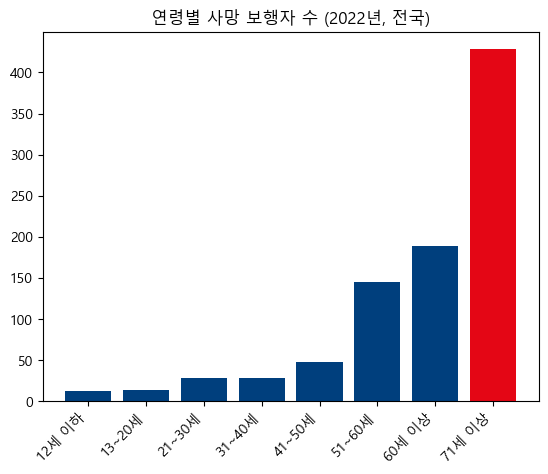

In [24]:
#쿼리 요청 및 결과
age_query = """
SELECT ages,
  SUM(death_toll) AS death_toll
FROM `Traffic_Accidents.Pedestrian_Age`
WHERE years = 2022 AND ages <> '기타'
GROUP BY ages
ORDER BY ages;
"""

age_list = []
death_list = []

for age, death in execute_query(age_query):
    age_list.append(age)
    death_list.append(death)

#분리되어있는 61~64세와 65~70세 레코드 합치기
death_list[6]=death_list[6]+death_list[7]
age_list[6] = '60세 이상'
del death_list[7]
del age_list[7]

#시각화
colors_c = ['#003f7d', '#003f7d', '#003f7d', '#003f7d', '#003f7d', '#003f7d', '#003f7d', '#e40615']
draw_bar_chart(age_list, death_list, chart_title = "연령별 사망 보행자 수 (2022년, 전국)", color_list=colors_c)

#### p.5 사망 보행자 유형별 비중 (2022년, 전국)

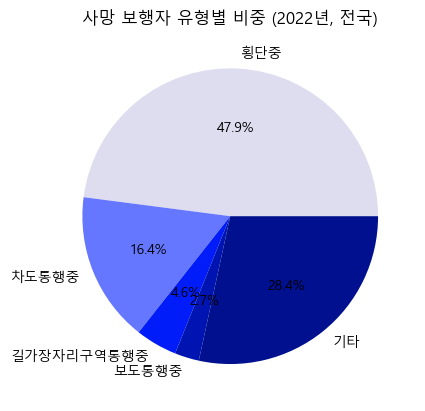

In [25]:
#쿼리 요청 및 결과
type_query = """
SELECT accident_type,
  SUM(death_toll) AS death_toll
FROM `Traffic_Accidents.Pedestrian_Type`
WHERE year = 2022
GROUP BY accident_type
ORDER BY death_toll DESC;
"""

type_list = []
death_list = []

for types, death in execute_query(type_query):
    type_list.append(types)
    death_list.append(death)

#'기타' 칼럼 마지막 순서로 변경
type_list.append(type_list[1])
death_list.append(death_list[1])

del type_list[1]
del death_list[1]

#시각화
colors_c = ['#DDDDEF', '#67f','#001cf9', '#0014b2','#00108e']
draw_pie_chart(type_list, death_list, chart_title = "사망 보행자 유형별 비중 (2022년, 전국)", color_list=colors_c)

### **가해자 특성**

#### p.6 가해 운전자 연령별 사망자 수 (2022년, 전국)

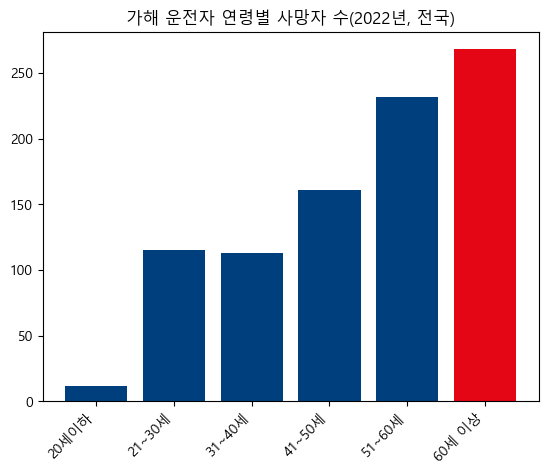

In [23]:
#쿼리 요청 및 결과
driver_age_query= """
SELECT ages,
  SUM(death_toll) AS death_toll
FROM `Traffic_Accidents.Driver`
WHERE years = 2022 AND ages <> '미분류'
GROUP BY ages
ORDER BY ages;
"""

age_list = []
death_list = []

for age, death in execute_query(driver_age_query):
    age_list.append(age)
    death_list.append(death)

#60대 칼럼 제작: 60~65세 / 65세~70세 데이터 병합
death_list[5]=death_list[5]+death_list[6]
age_list[5]='60세 이상'

del death_list[6]
del age_list[6]

#시각화
colors = ['#003f7d','#003f7d','#003f7d','#003f7d','#003f7d','#e40615']
draw_bar_chart(age_list, death_list, chart_title = "가해 운전자 연령별 사망자 수(2022년, 전국)", color_list=colors)

#### p.6 가해 운전자 성별 비중 (2022년, 전국)

for문 순회 완료


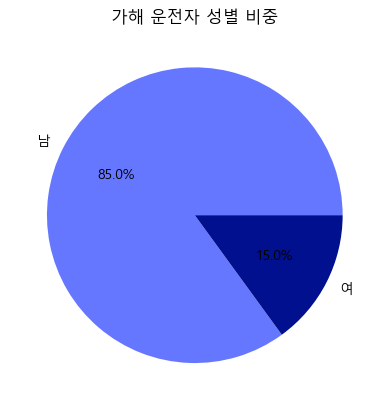

In [30]:
#쿼리 요청 및 결과
driver_gender_query = f"""
SELECT
  gender,
  SUM(counts),
  SUM(death_toll),
  SUM(serious_injury),
  SUM(minor_injury),
  SUM(injury_report)
FROM `Traffic_Accidents.Driver_Gender`
WHERE years = 2022 AND gender <> '기타불명'
GROUP BY gender
ORDER BY gender
"""

gender_list = []
total_list = []
death_list = []
serious_list = []
minor_list = []
report_list = []

for gender, total, death, serious, minor, report in execute_query(driver_gender_query):
    gender_list.append(gender)
    total_list.append(total)
    death_list.append(death)
    serious_list.append(serious)
    minor_list.append(minor)
    report_list.append(report)
print("for문 순회 완료")


#비중 계산
death_rate = []

cnt = 0
for i in death_list:
    cnt+=i

for i in death_list:
    death_rate.append(i/cnt*100)

cnt = 0
for i in death_rate:
    cnt+=i

#시각화
draw_pie_chart(gender_list, death_rate, chart_title = "가해 운전자 성별 비중", color_list=['#6677FF','#00108E'])

#### p.6 가해 차량 종류별 사망자 수 (2022년, 전국)

Text(0.5, 1.0, '2022년도 차량별 사망자 건수')

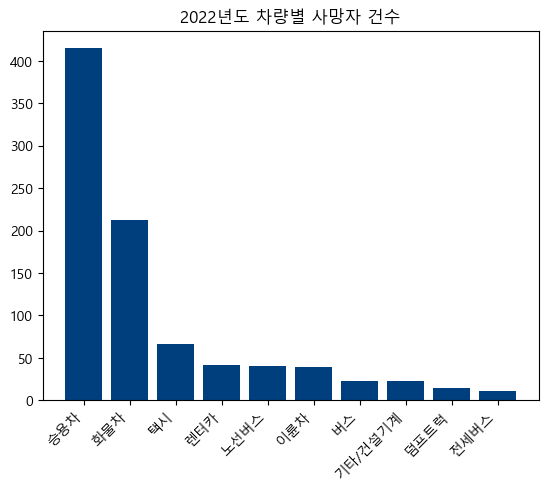

In [51]:
# 쿼리 작성
query = f"""
SELECT years,
  perpetrator_m,
  SUM(death_toll) AS total_accident
FROM `road-traffic-safety-388112.Traffic_Accidents.Perpetrator_montly`
WHERE years = 2022
GROUP BY years, perpetrator_m
ORDER BY years, total_accident DESC
LIMIT 10;
"""

# 쿼리 실행
query_job = client.query(query)

# 결과 가져오기
results = query_job.result()

# 결과 출력

v_year = []
x_car_type = []
y_accident = []

for year, car_type, accident in results:
    v_year.append(year)
    x_car_type.append(car_type)
    y_accident.append(accident)

plt.bar(x_car_type, y_accident, color = '#003F7D')
plt.xticks(rotation=45, ha='right')
plt.title("2022년도 차량별 사망자 건수")

### **환경적 특성**

#### p.7 월별 보행자 사망자 수(2022년, 전국)

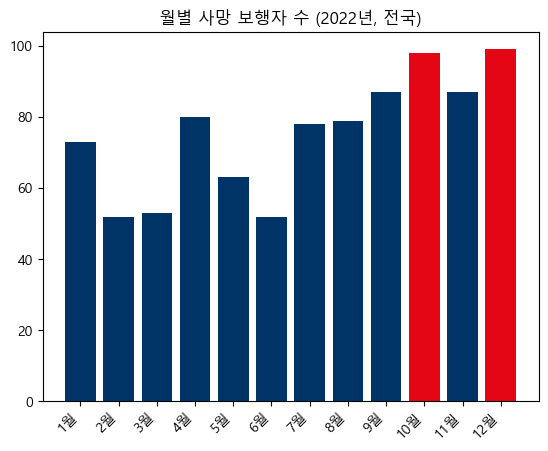

In [37]:
#쿼리 요청 및 결과
target_year = '2022'
by_month_query = f"""
SELECT FORMAT_TIMESTAMP('%m', DATE_TRUNC(dates, MONTH)) AS month,
       SUM(death_toll) AS total_counts
FROM Traffic_Accidents.Pedestrian
WHERE Pedestrian.dates >= DATE('{target_year}-01-01') AND Pedestrian.dates <= DATE('{target_year}-12-31')
GROUP BY month
ORDER BY month;
"""
month_list = []
death_list = []

for months, death in execute_query(by_month_query):
    month = f"{int(months)}월"
    month_list.append(month)
    death_list.append(death)

colors = ['#003366','#003366','#003366','#003366','#003366','#003366','#003366','#003366','#003366','#e40615','#003366','#e40615']
draw_bar_chart(month_list, death_list, chart_title = "월별 사망 보행자 수 (2022년, 전국)", color_list=colors)

#### p.7 요일별 사망자 수 (2022년, 전국)

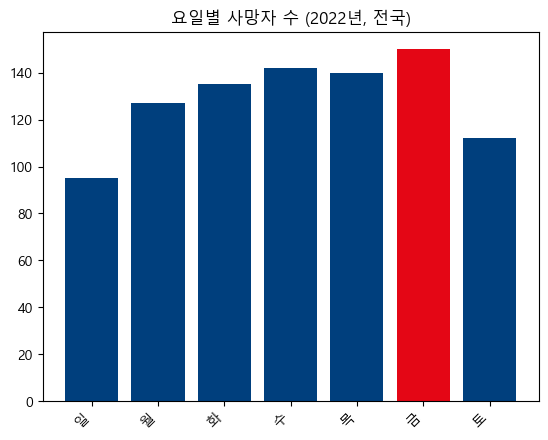

In [39]:
#쿼리 요청 및 결과
days_query = f"""
SELECT
    CASE day
        WHEN '일' THEN 1
        WHEN '월' THEN 2
        WHEN '화' THEN 3
        WHEN '수' THEN 4
        WHEN '목' THEN 5
        WHEN '금' THEN 6
        WHEN '토' THEN 7
  END AS days,
  SUM(death_toll) AS death_toll
FROM `Traffic_Accidents.Perpetrator_daily`
WHERE year = {target_year}
GROUP BY day
ORDER BY days;
"""

days_list = []
death_list = []

#요일 순서 정렬
for day, death in execute_query(days_query):
    if day == 1:
        day = '일'
    elif day == 2:
        day = '월'
    elif day == 3:
        day = '화'
    elif day == 4:
        day = '수'
    elif day == 5:
        day = '목'
    elif day == 6:
        day = '금'
    else:
        day = '토'
    days_list.append(day)
    death_list.append(death)

colors = ['#003f7d', '#003f7d','#003f7d','#003f7d','#003f7d','#e40615','#003f7d']
draw_bar_chart(days_list, death_list, chart_title=f"요일별 사망자 수 ({target_year}년, 전국)", color_list=colors)

#### p.7 시간대별 교통사고 사망자 수 (2022년, 전국)

Text(0.5, 1.0, '2022년도 시간대별 사망자 건수 (전국)')

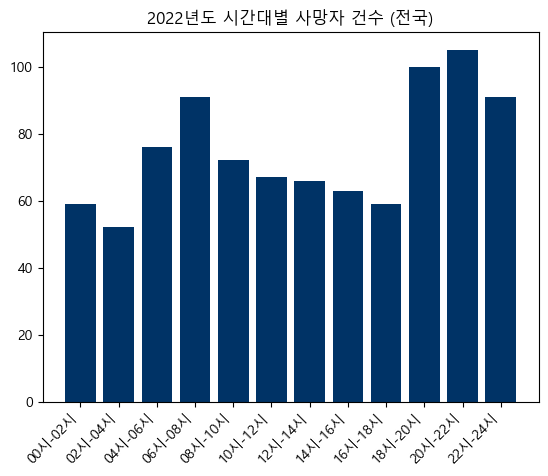

In [52]:
# 쿼리 작성
query = f"""
SELECT dates AS year,
  times,
  SUM(death_toll) AS total_death
FROM `road-traffic-safety-388112.Traffic_Accidents.Perpetrator_timeline`
WHERE dates = 2022
GROUP BY dates, times
ORDER BY dates, times;
"""

# 쿼리 실행
query_job = client.query(query)

# 결과 가져오기
results = query_job.result()

# 결과 출력
v_year = []
x_times = []
y_total_death = []

for year, times, total_death in results:
    v_year.append(year)
    x_times.append(times)
    y_total_death.append(total_death)

plt.bar(x_times, y_total_death, color='#003366')
plt.xticks(rotation=45, ha='right')

plt.title("2022년도 시간대별 사망자 건수 (전국)")

#### p.7 날씨별 사망 보행자 수 (2022년, 전국)

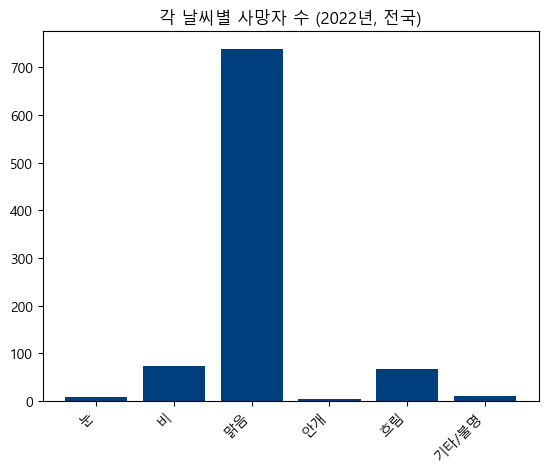

In [41]:
weather_query = f"""
SELECT
  weather AS Weather_Condition,
  SUM(death_toll) AS Death_Toll,
FROM `Traffic_Accidents.Weather`
WHERE years = 2022
GROUP BY weather;
"""

weather_condition = []
death_toll = []

for weather, death in execute_query(weather_query):
    weather_condition.append(weather)
    death_toll.append(death)

draw_bar_chart(weather_condition, death_toll, chart_title = "각 날씨별 사망자 수 (2022년, 전국)")


#### p.7 지역별 사망자 수 (2022년, 전국)

In [45]:
map_query = f"""
SELECT accident_type, law_violation_l, longitude, latitude
FROM `Traffic_Accidents.Death_Accidents`
WHERE dates >= DATE('2021-01-01')
  AND dates <= DATE('2021-12-31')
"""

map_list = []
for ped_type, law, lon, lat in execute_query(map_query):
    map_list.append([ped_type, law, lat, lon])


death_toll_map_seoul = folium.Map(location=[37.53897093698831, 127.05461953077439], zoom_strat=14) #지도 생성 및 초기화

for ped_type, law, lat, lon in map_list: #지도 위 표시
    folium.Circle([lat, lon], #위/경도
                        radius = 10, #원 크기
                        tooltip = ped_type, #마우스 커서 올렸을 때 정보
                        color = 'blue', #색상
                        fill = True).add_to(death_toll_map_seoul)
death_toll_map_seoul #지도 호출

#### p.7 서울시 사망자 수 지도 (2022년)

In [61]:
map_query = f"""
SELECT gungu, COUNT(gungu) AS counts
FROM `Traffic_Accidents.Death_Accidents`
WHERE (sido = '서울') AND dates >= DATE('2021-01-01') AND dates <= DATE('2021-12-31')
GROUP BY gungu"""
job = client.query(map_query)
result = job.result()

map_list = []
for gungu_text, guntu_count in result:
    map_list.append([gungu_text, guntu_count])

with open("./data/seoul.csv", "w", newline="", encoding="utf-8-sig") as fw:
    writer = csv.writer(fw)
    writer.writerow(["구", "개수"])
    writer.writerows(map_list)

file_path = './data/seoul.csv'
df = pd.read_csv(file_path, index_col="구")
df.columns = df.columns.map(str)

geo_path = "./data/seoul_municipalities_geo.json"

try:
    geo_data = json.load(open(geo_path, encoding="utf-8"))
except:
    geo_data = json.load(open(geo_path, encoding="utf-8-sig"))

g_map = folium.Map(location=[37.5665, 126.9780], tiles="Stamen Terrain", zoom_start=9)

col = "개수"

folium.Choropleth(geo_data=geo_data,
                  data=df[col],
                  columns=[df.index, df[col]],
                  fill_color='YlOrRd',
                  fill_opacity=0.7,
                  line_opacity=0.3,
                  threshold_scale=[0, 5, 10, 15],
                  key_on='feature.properties.SIG_KOR_NM'
                  # key_on='feature.properties.name'
                  ).add_to(g_map)

g_map